# Major airports (Arranged according to traffic they handle)

In [1]:
from mpl_toolkits.basemap import Basemap
m = Basemap(resolution='c',
            projection='kav7',
            lat_0=0., # Center around
            lon_0=0.) # lat 0, lon 0

In [2]:
import pandas as pd

import geopandas
from shapely.geometry import Point

import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
%matplotlib inline

In [13]:
raw_data = '../Data/raw_data/'
columns =['Source_Airport', 'Airport_start','City_start' ,'Country_start' ,'Longitude_start', 'Latitude_start']
allroutes = pd.read_csv(raw_data +'MultiRoutesData.csv' , low_memory=False)

In [14]:

international_routes = allroutes[allroutes['Country_start'] != allroutes['Country_end']].reset_index()
international_routes = international_routes.dropna(subset=columns)
#international_routes.drop_duplicates(['Source_Airport_ID','Destination_Airport_ID'], inplace=True)

In [18]:
grouped1 = international_routes.groupby(columns) 
grouped2 = international_routes.groupby(['Destination_Airport'])
major_hubs1 = pd.DataFrame({'Outbound Flights #' : grouped1[columns].size()}).reset_index()
major_hubs2 = pd.DataFrame({'Inbound Flights #' : grouped2['Destination_Airport'].size()}).reset_index()
major_hub = major_hubs1.merge(major_hubs2, left_on='Source_Airport', right_on='Destination_Airport')
major_hub.drop(['Destination_Airport'], axis=1, inplace=True)
major_hub.rename(columns={'Source_Airport':"Hub", 'Longitude_start' : 'Longitude', 'Latitude_start' : 'Latitude'}, inplace=True)
major_hub.sort_values(by=['Outbound Flights #', 'Inbound Flights #'], ascending=[False, False], inplace=True)
major_hub['traffic'] = major_hub['Outbound Flights #'] + major_hub['Inbound Flights #']
major_hub = major_hub.reset_index(drop=True)
major_hub.head()

,Hub,Airport_start,City_start,Country_start,Longitude,Latitude,Outbound Flights #,Inbound Flights #,traffic
0,LHR,Heathrow,London,United Kingdom,-0.461389,51.477500,499,496,995
1,CDG,Charles De Gaulle,Paris,France,2.550000,49.012779,488,482,970
2,FRA,Frankfurt Main,Frankfurt,Germany,8.543125,50.026421,478,472,950
3,AMS,Schiphol,Amsterdam,Netherlands,4.763889,52.308613,453,450,903
4,SIN,Changi Intl,Singapore,Singapore,103.994433,1.350189,408,412,820


In [19]:
# combine lat and lon column to a shapely Point() object
major_hub['geometry'] = major_hub.apply(lambda x: Point((float(x.Longitude), float(x.Latitude))), axis=1)
major_hub = geopandas.GeoDataFrame(major_hub, geometry='geometry')
major_hub.to_file('../Extras/MyGeometries.shp', driver='ESRI Shapefile', encoding='utf-8')

/Users/sumitdeshmukh/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning:

The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.

/Users/sumitdeshmukh/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

/Users/sumitdeshmukh/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.



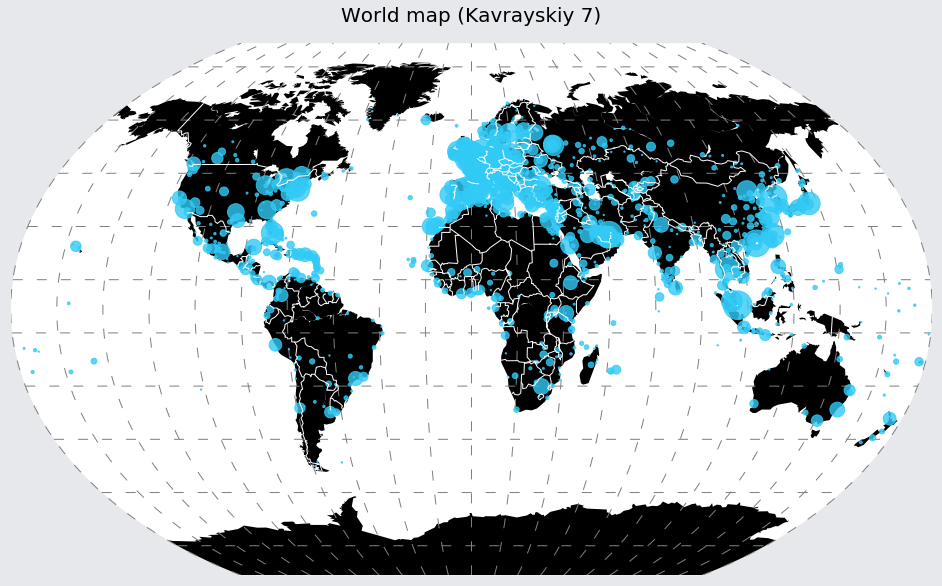

In [20]:
n_graticules = 18
parallels = np.arange(-80., 90, n_graticules)
meridians = np.arange(0., 360., n_graticules)
lw = 1
dashes = [5,7] # 5 dots, 7 spaces... repeat
graticules_color = 'grey'

fig1 = plt.figure(figsize=(16,20))
fig1.patch.set_facecolor('#e6e8ec')
ax = fig1.add_axes([0.1,0.1,0.8,0.8])

m.drawmapboundary(color='white', 
                  linewidth=0.0, 
                  fill_color='white')
m.drawparallels(parallels, 
                linewidth=lw, 
                dashes=dashes, 
                color=graticules_color)
m.drawmeridians(meridians, 
                linewidth=lw, 
                dashes=dashes, 
                color=graticules_color)
m.drawcoastlines(linewidth=0)
m.fillcontinents('black', 
                 lake_color='white')
m.drawcountries(linewidth=1, 
                linestyle='solid', 
                color='white', 
                zorder=30)

title = plt.title('World map (Kavrayskiy 7)', 
                  fontsize=20) 
title.set_y(1.03) # Move the title a bit

m.readshapefile('../Extras/MyGeometries', 
                name='airports_shape', 
                drawbounds=False, 
                color='none')

out_traffic = [r['traffic'] for r in m.airports_shape_info]
lats = [r['Latitude'] for r in m.airports_shape_info]
lons = [r['Longitude'] for r in m.airports_shape_info]
x1, y1 = m(lons, lats) # Convert coords to projected place in figure
m.scatter(x1, y1, 
          s=np.array(out_traffic), 
          marker="o", 
          color='#32caf6',
          zorder=10, 
          alpha=0.8)

plt.show()
#plt.savefig('Output/images/world2.png', format='png', bbox_inches='tight')
plt.close()

In [29]:

major_hub['text'] = major_hub['Airport_start'] + '<br>City ' + major_hub['City_start']+ '<br>Country '\
                    + major_hub['Country_start']
limits = [(0,10),(11,40),(41,100),(101,500),(251,1160)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","lightgrey"]
airports = []
scale = 1

for i in range(len(limits)):
    lim = limits[i]
    df_sub = major_hub[lim[0]:lim[1]]
    airport = dict(
        type = 'scattergeo',
        locationmode = 'country names',
        lon = df_sub['Longitude'],
        lat = df_sub['Latitude'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['traffic']/scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = 'Top {0}'.format(lim[1]))
    airports.append(airport)

layout = dict(
        title = 'Air traffic hubs<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope='world',
            projection=dict( type='equirectangular' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=airports, layout=layout )
py.iplot( fig, validate=False, filename='d3-bubble-map-Airtraffic' )

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~sumitdeshmukh/0 or inside your plot.ly account where it is named 'd3-bubble-map-Airtraffic'
